In [1]:
import os
from ase.io import read
from ase import Atoms
from MCPoly.lmpset import DataToXyz
import numpy as np

def near(atomnum, atoms, tolerance=2.000):
    atoms_not_H = []
    for i, atom in enumerate(atoms):
        if atom.symbol != 'H':
            atoms_not_H.append(i)
    mole = [atomnum]
    pre_distances = atoms.get_distances(atomnum, atoms_not_H)
    distances = np.delete(pre_distances, np.where(pre_distances >= tolerance))
    distances = np.delete(distances, np.where(distances == 0))
    distances.sort()
    length = len(distances)
    if length > 4:
        distances = distances[:4]
    for i, atom in enumerate(atoms_not_H):
        distance = atoms.get_distance(atom, atomnum)
        if distance in distances:
            mole.append(atom)
    return mole

def molesplit(file, loc='./', atomnum=0, tolerance=2.000, withH=False,\
              form='XYZ', must_bonds={}):
    reverse = []
    if must_bonds != {}:
        for i,key in enumerate(must_bonds.keys()):
            for j,value in enumerate(must_bonds.values()):
                if i == j:
                    reverse.append([key, value])
    for couple in reverse:
        must_bonds[couple[1]] = couple[0]
    opath = os.getcwd()
    os.chdir(loc)
    if form == 'XYZ':
        atoms = read(file+'.xyz')
    elif form == 'LAMMPSDATA':
        DataToXyz(file)
        atoms = read(file+'.xyz')
    atoms_not_H = []
    atoms_H = []
    for i, atom in enumerate(atoms):
        if atom.symbol != 'H':
            atoms_not_H.append(i)
        else:
            atoms_H.append(i)
    mole = near(atomnum, atoms, tolerance=tolerance)
    if atomnum in must_bonds.keys():
        mole.append(must_bonds[atomnum])
    i = 1
    while 1:
        molefrag = near(mole[i], atoms, tolerance=tolerance)
        if mole[i] in must_bonds.keys():
            molefrag.append(must_bonds[mole[i]])
        for num in molefrag:
            if num not in mole:
                mole.append(num)
        i = i + 1
        try:
            mole[i] == mole[-1]
        except:
            break
    if withH == True:
        mole_H = []
        for atom in mole:
            pre_distances = atoms.get_distances(atom, atoms_H)
            distances = np.delete(pre_distances, np.where(pre_distances >= 1.2))
            for H in atoms_H:
                distance = atoms.get_distance(H, atom)
                if distance in distances:
                    mole_H.append(H)
        mole = mole + mole_H
    if form == 'LAMMPSDATA':
        os.system('rm {0}.xyz'.format(file))
    os.chdir(opath)
    return mole

def near(atomnum, atoms, tolerance=2.000):
    atoms_not_H = []
    for i, atom in enumerate(atoms):
        if atom.symbol != 'H':
            atoms_not_H.append(i)
    mole = [atomnum]
    pre_distances = atoms.get_distances(atomnum, atoms_not_H)
    distances = np.delete(pre_distances, np.where(pre_distances >= tolerance))
    distances = np.delete(distances, np.where(distances == 0))
    distances.sort()
    length = len(distances)
    if length > 4:
        distances = distances[:4]
    for i, atom in enumerate(atoms_not_H):
        distance = atoms.get_distance(atom, atomnum)
        if distance in distances:
            mole.append(atom)
    return mole

def nearH(atomnum, atoms, tolerance=1.200):
    atoms_H = []
    for i, atom in enumerate(atoms):
        if atom.symbol == 'H':
            atoms_H.append(i)
    mole = [atomnum]
    pre_distances = atoms.get_distances(atomnum, atoms_H)
    distances = np.delete(pre_distances, np.where(pre_distances >= tolerance))
    distances = np.delete(distances, np.where(distances <= 0.5))
    distances.sort()
    length = len(distances)
    if length > 3:
        distances = distances[:4]
    for i, atom in enumerate(atoms_H):
        distance = atoms.get_distance(atom, atomnum)
        if distance in distances:
            mole.append(atom)
    return mole

def smileorder(file, loc='./', atomnum=0, tolerance=2.000, toleranceH=1.200,\
               form='XYZ', must_bonds={}):
    reverse = []
    if must_bonds != {}:
        for i,key in enumerate(must_bonds.keys()):
            for j,value in enumerate(must_bonds.values()):
                if i == j:
                    reverse.append([key, value])
    for couple in reverse:
        must_bonds[couple[1]] = couple[0]
    opath = os.getcwd()
    os.chdir(loc)
    if form == 'XYZ':
        atoms = read(file+'.xyz')
    elif form == 'LAMMPSDATA':
        DataToXyz(file, savename = 'soload')
        atoms = read('soload.xyz')
    atoms_not_H = []
    atoms_H = []
    for i, atom in enumerate(atoms):
        if atom.symbol != 'H':
            atoms_not_H.append(i)
        else:
            atoms_H.append(i)
    mole = near(atomnum, atoms, tolerance=tolerance)
    if atomnum in must_bonds.keys():
        mole.append(must_bonds[atomnum])
    i = 1
    while 1:
        molefrag = near(mole[i], atoms, tolerance=tolerance)
        if mole[i] in must_bonds.keys():
            molefrag.append(must_bonds[mole[i]])
        for num in molefrag:
            if num not in mole:
                mole.append(num)
        i = i + 1
        try:
            mole[i] == mole[-1]
        except:
            break
    fullmole = []
    for num in mole:
        fullmole.append(num)
        moleHfrag = nearH(num, atoms, tolerance=toleranceH)
        for num2 in moleHfrag:
            if num2 not in mole:
                fullmole.append(num2)
    if form == 'LAMMPSDATA':
        os.system('rm soload.xyz')
    os.chdir(opath)
    return fullmole

In [2]:
from ase.io import read
from ase import Atoms
import numpy as np
import re

def HBondNum(file, HBond=2.0):
    atoms = read(file+'.xyz')
    atoms_H_bond = []
    atoms_H = []
    angle_group = []
    
    for i, atom in enumerate(atoms):
        if atom.symbol == 'O':
            atoms_H_bond.append(i)
        elif atom.symbol == 'F':
            atoms_H_bond.append(i)
        elif atom.symbol == 'N':
            atoms_H_bond.append(i)
        if atom.symbol == 'H':
            atoms_H.append(i)

    for atom2 in atoms_H:
        distances = atoms.get_distances(atom2, atoms_H_bond)
        targets = np.delete(distances, np.where(distances >= HBond))
        targets.sort()
        pre_angle_group = []
        
        if len(targets) >= 2:
            pre_angle_group = [''] * (len(targets) * 2)
            if targets[0] >= 1.2:
                continue
            for i, atom in enumerate(atoms_H_bond):
                distance = atoms.get_distance(atom, atom2)
                for k,target in enumerate(targets):
                    if abs(distance - target) < 1E-5:
                        if atom not in angle_group:
                            #print(atom)
                            pre_angle_group[2*k] = atom
                        pre_angle_group[2*k+1] = atom2
                        #print(pre_angle_group)
                    #if atom2 == 323:
                        #print(pre_angle_group)
                        break
        #print(atom, atom2)
        
        j = 2
        for j in range(2,len(targets)+1):
            #print(len(targets)+1)
            #print(pre_angle_group[0], pre_angle_group[1], pre_angle_group[2*j-2], atoms.get_angle(pre_angle_group[0], pre_angle_group[1],pre_angle_group[2*j-2]))
            if atoms.get_angle(pre_angle_group[0], pre_angle_group[1],\
                               pre_angle_group[2*j-2]) >= 120:
                part1 = molesplit(file, atomnum=pre_angle_group[0])
                if pre_angle_group[2*j-2] in part1:
                    continue
                angle_group.append([pre_angle_group[0], pre_angle_group[1],\
                                    pre_angle_group[2*j-2]])
                break
                
    return angle_group

num = 0.000
file = 'S1M'
f = open('{0}_HBonds.txt'.format(file), 'w')
f.write('Stress Force(nN),HBonds\n')
files = []
for path in os.listdir('./'):
    if os.path.isfile(os.path.join('./', path)):
        a = re.match(file+'_', path)
        if a:
            b = re.search('.xyz', path)
            if b:
                files.append(path[:-4])
files.sort()
for newfile in files:
    angle_group = HBondNum(newfile, HBond=2.2)
    print(f'{num:.3f}:', len(angle_group))
    f.write('{0:.3f},{1}\n'.format(num, len(angle_group)))
    num = num + 0.020
f.close()

0.000: 3
0.020: 3
0.040: 3
0.060: 3
0.080: 3
0.100: 3
0.120: 3
0.140: 3
0.160: 3
0.180: 3
0.200: 3
0.220: 3
0.240: 3
0.260: 3
0.280: 3
0.300: 3
0.320: 3
0.340: 3
0.360: 3
0.380: 3
0.400: 3
0.420: 3
0.440: 3
0.460: 2
0.480: 2
0.500: 2
0.520: 2
0.540: 2
0.560: 2
0.580: 2
0.600: 2
0.620: 2
0.640: 1
0.660: 2
0.680: 2
0.700: 2
0.720: 1
0.740: 1
0.760: 1
0.780: 0
0.800: 0
0.820: 0
0.840: 0
0.860: 0
0.880: 0
0.900: 0
0.920: 0
0.940: 0


In [15]:
import matplotlib.pyplot as plt
from ase.io import read
from ase import Atoms
import os
import re

def crossover_num(file, atomnum, screen='z', shadow_tolerance=1.25, height_tolerance=3.5):
    atoms = read(file+'.xyz')
    
    mole = molesplit(file, atomnum=atomnum[0])
    mole2 = molesplit(file, atomnum=atomnum[1])
    mole_not_H_x = []
    mole_not_H_y = []
    mole_not_H_z = []
    mole2_not_H_x = []
    mole2_not_H_y = []
    mole2_not_H_z = []
    linkers = []
    linker_pos = []
    crossover = 0
    
    for i in mole:
        mole_not_H_x.append(atoms[i].position[0])
        mole_not_H_y.append(atoms[i].position[1])
        mole_not_H_z.append(atoms[i].position[2])
    
    for i in mole2:
        mole2_not_H_x.append(atoms[i].position[0])
        mole2_not_H_y.append(atoms[i].position[1])
        mole2_not_H_z.append(atoms[i].position[2])
    
    if screen in ('z', 'Z'):
        linkers.append([0,0])
        if mole_not_H_z[0] - mole2_not_H_z[0] > 0:
            linker_pos.append(1)
        else:
            linker_pos.append(-1)
        
        for i1, x1 in enumerate(mole_not_H_x):
            for i2, x2 in enumerate(mole2_not_H_x):
                if ((mole_not_H_x[i1] - mole2_not_H_x[i2]) ** 2
                    + (mole_not_H_y[i1] - mole2_not_H_y[i2]) ** 2 <= shadow_tolerance ** 2):
                    if abs(mole_not_H_z[i1] - mole2_not_H_z[i2]) >= height_tolerance:
                        linkers.append([i1, i2])
                        if mole_not_H_z[i1] - mole2_not_H_z[i2] > 0:
                            linker_pos.append(1)
                        else:
                            linker_pos.append(-1)
                        break
    
        linkers.append([len(mole)-1, len(mole2)-1])
        if mole_not_H_z[-1] - mole2_not_H_z[-1] > 0:
            linker_pos.append(1)
        else:
            linker_pos.append(-1)
    elif screen in ('y', 'Y'):
        linkers.append([0,0])
        if mole_not_H_y[0] - mole2_not_H_y[0] > 0:
            linker_pos.append(1)
        else:
            linker_pos.append(-1)
        
        for i1, x1 in enumerate(mole_not_H_x):
            for i2, x2 in enumerate(mole2_not_H_x):
                if ((mole_not_H_x[i1] - mole2_not_H_x[i2]) ** 2
                    + (mole_not_H_z[i1] - mole2_not_H_z[i2]) ** 2 <= shadow_tolerance ** 2):
                    if abs(mole_not_H_y[i1] - mole2_not_H_y[i2]) >= height_tolerance:
                        linkers.append([i1, i2])
                        if mole_not_H_y[i1] - mole2_not_H_y[i2] > 0:
                            linker_pos.append(1)
                        else:
                            linker_pos.append(-1)
                        break
    
        linkers.append([len(mole)-1, len(mole2)-1])
        if mole_not_H_y[-1] - mole2_not_H_y[-1] > 0:
            linker_pos.append(1)
        else:
            linker_pos.append(-1)
    elif screen in ('x', 'X'):
        linkers.append([0,0])
        if mole_not_H_x[0] - mole2_not_H_x[0] > 0:
            linker_pos.append(1)
        else:
            linker_pos.append(-1)
        
        for i1, x1 in enumerate(mole_not_H_x):
            for i2, x2 in enumerate(mole2_not_H_x):
                if ((mole_not_H_y[i1] - mole2_not_H_y[i2]) ** 2
                    + (mole_not_H_z[i1] - mole2_not_H_z[i2]) ** 2 <= shadow_tolerance ** 2):
                    if abs(mole_not_H_x[i1] - mole2_not_H_x[i2]) >= height_tolerance:
                        linkers.append([i1, i2])
                        if mole_not_H_x[i1] - mole2_not_H_x[i2] > 0:
                            linker_pos.append(1)
                        else:
                            linker_pos.append(-1)
                        break
    
        linkers.append([len(mole)-1, len(mole2)-1])
        if mole_not_H_x[-1] - mole2_not_H_x[-1] > 0:
            linker_pos.append(1)
        else:
            linker_pos.append(-1)
        
    for i, stat in enumerate(linker_pos):
        try:
            if i > 0:
                if linker_pos[i] != linker_pos[i+1] and linker_pos[i] != linker_pos[i-1]:
                    linker_pos[i] = linker_pos[i-1]
                continue
        except:
            pass
    for i, stat in enumerate(linker_pos):
        try:
            if linker_pos[i] != linker_pos[i+1]:
                crossover = crossover + 1
        except:
            pass
    #print(linkers, linker_pos)
    return crossover

num = 0.000
file = 'N5'
f = open('{0}_Cross.txt'.format(file), 'w')
f.write('Stress Force(nN),Crossovers\n')
files = []
for path in oNs.listdir('./'):
    if os.path.isfile(os.path.join('./', path)):
        a = re.match(file+'_', path)
        if a:
            b = re.search('.xyz', path)
            if b:
                files.append(path[:-4])
files.sort()
for newfile in files:
    crossovers = crossover_num(newfile, atomnum=[86, 221], screen='x', shadow_tolerance=1, height_tolerance=2)
    print(f'{num:.3f}:', crossovers)
    f.write('{0:.3f},{1}\n'.format(num, str(crossovers)))
    num = num + 0.020
f.close()

0.000: 4
0.020: 6
0.040: 4
0.060: 6
0.080: 4
0.100: 5
0.120: 5
0.140: 7
0.160: 3
0.180: 3
0.200: 3
0.220: 7
0.240: 4
0.260: 4
0.280: 4
0.300: 5
0.320: 5
0.340: 3
0.360: 3
0.380: 3
0.400: 3
0.420: 3
0.440: 2
0.460: 4
0.480: 4
0.500: 4
0.520: 4
0.540: 4
0.560: 2
0.580: 4
0.600: 4
0.620: 4
0.640: 4
0.660: 2
0.680: 2
0.700: 6
0.720: 4
0.740: 4
0.760: 4
0.780: 4
0.800: 2
0.820: 0
0.840: 0
0.860: 0
0.880: 0
0.900: 0
0.920: 0
0.940: 0
0.960: 4
0.980: 4
1.000: 4
1.020: 4
1.040: 4
1.060: 4
1.080: 4
1.100: 2
1.120: 4
1.140: 2
1.160: 6
1.180: 2
1.200: 6
1.220: 0
1.240: 2
1.260: 2
1.280: 4
1.300: 2
1.320: 2
1.340: 2
1.360: 2
1.380: 2
1.400: 4


['S1M_0.340.xyz', 'S1M_0.220.xyz', 'S1M_0.180.xyz', 'S1M_0.380.xyz', 'S1M_0.800.xyz', 'S1M_0.020.xyz', 'S1M_0.140.xyz', 'S1M_0.420.xyz', 'S1M_0.540.xyz', 'S1M_0.780.xyz', 'S1M_0.580.xyz', 'S1M_0.740.xyz', 'S1M_0.620.xyz', 'S1M_0.860.xyz', 'S1M_0.900.xyz', 'S1M_0.280.xyz', 'S1M_0.040.xyz', 'S1M_0.120.xyz', 'S1M_0.320.xyz', 'S1M_0.240.xyz', 'S1M_0.080.xyz', 'S1M_0.480.xyz', 'S1M_0.720.xyz', 'S1M_0.640.xyz', 'S1M_0.440.xyz', 'S1M_0.520.xyz', 'S1M_0.680.xyz', 'S1M_0.100.xyz', 'S1M_0.060.xyz', 'S1M_0.920.xyz', 'S1M_0.840.xyz', 'S1M_0.260.xyz', 'S1M_0.880.xyz', 'S1M_0.300.xyz', 'S1M_0.660.xyz', 'S1M_0.700.xyz', 'S1M_0.500.xyz', 'S1M_0.460.xyz', 'S1M_0.200.xyz', 'S1M_0.360.xyz', 'S1M_0.160.xyz', 'S1M_0.000.xyz', 'S1M_0.940.xyz', 'S1M_0.820.xyz', 'S1M_0.560.xyz', 'S1M_0.400.xyz', 'S1M_0.600.xyz', 'S1M_0.760.xyz']
    Force(nN)  Distance(Å)
0        0.00      0.00000
1        0.02      2.92613
2        0.04      3.85514
3        0.06      4.35551
4        0.08      5.15057
5        0.10      5.

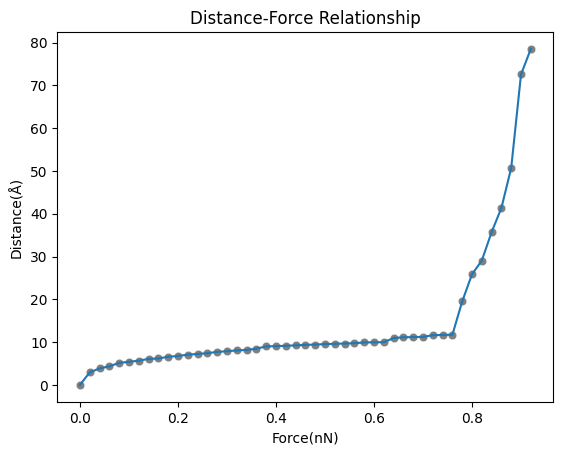

In [3]:
from MCPoly.sscurve import single

poly1=single('S1M')
poly1.curve2(113, 292, savefig=False)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

polymer=input('Polymer File Name:')

distance = pd.read_csv('{0}_Result.txt'.format(polymer))
hb = pd.read_csv('{0}_HBonds.txt'.format(polymer))
cross = pd.read_csv('{0}_Cross.txt'.format(polymer))

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(5, 7))
# Remove vertical space between axes
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
#axs[0].plot(t, s1)
#axs[0].set_yticks(np.arange(-0.9, 1.0, 0.4))
#axs[0].set_ylim(-1, 1)
axs[-1].plot(distance['Force(nN)'], distance['Distance(Å)'], '*-r')
axs[-1].set_xlabel('Force(nN)')
axs[-1].set_ylabel('Distance(Å)')
#_ = plt.title('Distance-Force Relationship')

#axs[1].plot(t, s2)
axs[1].set_yticks(np.arange(0, 10, 1))
#axs[1].set_ylim(0, 1)
#axs[-2].plot(hb['HBonds'], hb['Stress Force(nN)'], '*-')
axs[-2].plot(hb['Stress Force(nN)'], hb['HBonds'], '*-')
#axs.xlabel('Force(nN)')
axs[-2].set_ylabel('Hydrogen Bonds')
#_ = plt.title('Distance-Force Relationship')

#axs[1].plot(t, s2)
axs[-3].set_yticks(np.arange(0,10,1))
#axs[1].set_ylim(0, 1)
#axs[-3].plot(cross['HBonds'], cross['Stress Force(nN)'], '*-')
axs[-3].plot(cross['Stress Force(nN)'], cross['Crossovers'], '*-g')
#axs.xlabel('Force(nN)')
axs[-3].set_ylabel('Crossovers')
axs[-3].set_title('Polymer Chain Index Figures')

#axs[2].plot(t, s3)
#axs[2].set_yticks(np.arange(-0.9, 1.0, 0.4))
#axs[2].set_ylim(-1, 1)
plt.savefig('{0}.png'.format(polymer))
plt.show()

Polymer File Name: S


FileNotFoundError: [Errno 2] No such file or directory: 'S_Result.txt'

<Figure size 600x900 with 0 Axes>

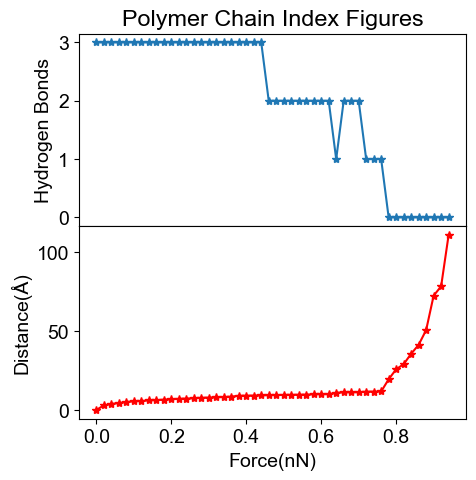

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

polymer = 'S1M'
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(9)

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'Arial'})

distance = pd.read_csv('{0}_Result.txt'.format(polymer))
hb = pd.read_csv('{0}_HBonds.txt'.format(polymer))
#cross = pd.read_csv('{0}_Cross.txt'.format(polymer))

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
# Remove vertical space between axes
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
#axs[0].plot(t, s1)
#axs[0].set_yticks(np.arange(-0.9, 1.0, 0.4))
#axs[0].set_ylim(-1, 1)
axs[-1].plot(distance['Force(nN)'], distance['Distance(Å)'], '*-r')
axs[-1].set_xlabel('Force(nN)')
axs[-1].set_ylabel('Distance(Å)')
#_ = plt.title('Distance-Force Relationship')

#axs[1].plot(t, s2)
axs[0].set_yticks(np.arange(0, 10, 1))
#axs[1].set_ylim(0, 1)
#axs[-2].plot(hb['HBonds'], hb['Stress Force(nN)'], '*-')
axs[-2].plot(hb['Stress Force(nN)'], hb['HBonds'], '*-')
#axs.xlabel('Force(nN)')
axs[-2].set_ylabel('Hydrogen Bonds')
#_ = plt.title('Distance-Force Relationship')
axs[-2].set_title('Polymer Chain Index Figures')

#axs[1].plot(t, s2)
#axs[-3].set_yticks(np.arange(0,10,1))
#axs[1].set_ylim(0, 1)
#axs[-3].plot(cross['HBonds'], cross['Stress Force(nN)'], '*-')
#axs[-3].plot(cross['Stress Force(nN)'], cross['Crossovers'], '*-g')
#axs.xlabel('Force(nN)')
#axs[-3].set_ylabel('Crossovers')

#axs[2].plot(t, s3)
#axs[2].set_yticks(np.arange(-0.9, 1.0, 0.4))
#axs[2].set_ylim(-1, 1)
#plt.savefig('{0}.png'.format(polymer))
plt.savefig('{0}_svg.svg'.format(polymer), format='svg', bbox_inches='tight', dpi=350)
plt.show()

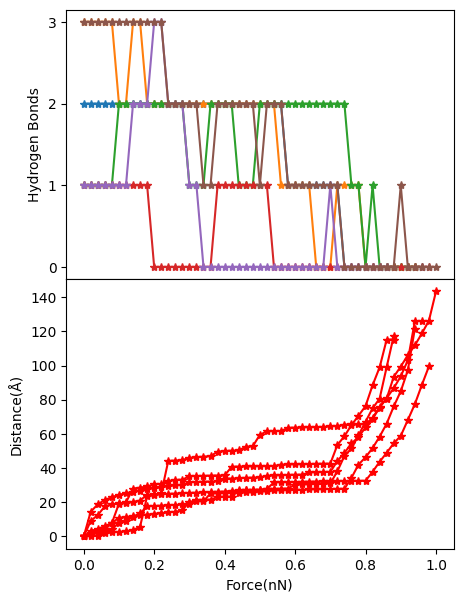

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

polymers = ['B','N','NN','NO','S','SS']
pattern = '4'

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 7))
# Remove vertical space between axes
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
for polymer in polymers:
    distance = pd.read_csv('{0}{1}_Result.txt'.format(polymer, pattern))
    hb = pd.read_csv('{0}{1}_HBonds.txt'.format(polymer, pattern))
    #cross = pd.read_csv('{0}_Cross.txt'.format(polymer))

    #axs[0].plot(t, s1)
    #axs[0].set_yticks(np.arange(-0.9, 1.0, 0.4))
    #axs[0].set_ylim(-1, 1)
    axs[-1].plot(distance['Force(nN)'], distance['Distance(Å)'], '*-r')
    axs[-1].set_xlabel('Force(nN)')
    axs[-1].set_ylabel('Distance(Å)')
    #_ = plt.title('Distance-Force Relationship')

    #axs[1].plot(t, s2)
    axs[-2].set_yticks(np.arange(0, 10, 1))
    #axs[1].set_ylim(0, 1)
    #axs[-2].plot(hb['HBonds'], hb['Stress Force(nN)'], '*-')
    axs[-2].plot(hb['Stress Force(nN)'], hb['HBonds'], '*-')
    #axs.xlabel('Force(nN)')
    axs[-2].set_ylabel('Hydrogen Bonds')
    #_ = plt.title('Distance-Force Relationship')
    
    #axs[1].plot(t, s2)
    #axs[-3].set_yticks(np.arange(0,10,1))
    #axs[1].set_ylim(0, 1)
    #axs[-3].plot(cross['HBonds'], cross['Stress Force(nN)'], '*-')
    #axs[-3].plot(cross['Stress Force(nN)'], cross['Crossovers'], '*-g')
    #axs.xlabel('Force(nN)')
    #axs[-3].set_ylabel('Crossovers')
    #axs[-3].set_title('Polymer Chain Index Figures')

    #axs[2].plot(t, s3)
    #axs[2].set_yticks(np.arange(-0.9, 1.0, 0.4))
    #axs[2].set_ylim(-1, 1)
plt.savefig('{0}.png'.format(polymer))
plt.show()